In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import SGDClassifier

import tensorflow as tf
from tensorflow.keras.optimizers.schedules import PolynomialDecay

from transformers import AutoTokenizer, DataCollatorWithPadding
from transformers import TFAutoModelForSequenceClassification
from transformers import AdamWeightDecay
from datasets import Dataset, DatasetDict

print(tf.__version__)
print(tf.config.list_physical_devices())

# startegy for training on multiple gpus
mirrored_strategy = tf.distribute.MirroredStrategy()

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


2.11.0
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [2]:
dataset = pd.read_csv('../input/reduced-edos/EDOS 1M - 1.csv')
X,y = dataset["uttr"], dataset["eb+_emot"]

print(X.head(5))
print(type(X), end="\n\n")
print(y.head(5))
print(type(y), end="\n\n")

classes = y.unique()
classes

0                   Damn ! What the hell is going on ?
1                                       Fucking pigs .
2               We 'll soon leave . I 'm also fed up .
3    Oh , what the fuck ? ! Is this another dream ?...
4    Are you mad ? We can hardly breathe . We 'll b...
Name: uttr, dtype: object
<class 'pandas.core.series.Series'>

0    angry
1    angry
2    angry
3    angry
4    angry
Name: eb+_emot, dtype: object
<class 'pandas.core.series.Series'>



array(['angry', 'furious', 'prepared', 'acknowledging', 'trusting',
       'confident', 'hopeful', 'caring', 'sentimental', 'anticipating',
       'wishing', 'surprised', 'ashamed', 'questioning', 'sad',
       'nostalgic', 'devastated', 'terrified', 'embarrassed', 'lonely',
       'encouraging', 'suggesting', 'content', 'afraid', 'impressed',
       'agreeing', 'apprehensive', 'proud', 'annoyed', 'anxious',
       'grateful', 'excited', 'neutral', 'faithful', 'guilty',
       'consoling', 'disgusted', 'disappointed', 'jealous', 'joyful',
       'sympathizing'], dtype=object)

# Preparation

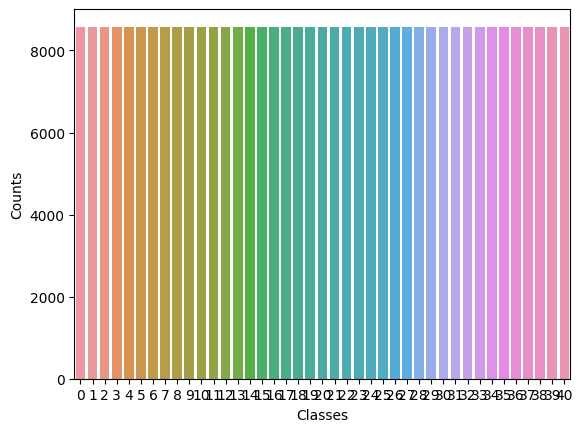

In [3]:
# plot classes distribution
counts = pd.get_dummies(y).sum()

plt.ylabel('Counts')
plt.xlabel('Classes')
sns.barplot(x = [i for i in range(len(classes))], y = counts)
plt.show()

In [4]:
# train, validation and test split
train_X, valid_X, train_y, valid_y = train_test_split(X, y, test_size=0.2, stratify=y)

print("train size: ", len(train_X))
print("validation size: ", len(valid_X))

train size:  281358
validation size:  70340


# Single utterance classification - Baseline model

In [5]:
# vectorize the text using word count
vectorizer = CountVectorizer(min_df=5, stop_words='english')
vectorizer.fit(train_X)
print("Vocabulary length: " + str(len(vectorizer.get_feature_names_out())))
print("First words: " + str(vectorizer.get_feature_names_out()[:200]))

train_X_vector = vectorizer.transform(train_X)
valid_X_vector = vectorizer.transform(valid_X)

Vocabulary length: 18813
First words: ['00' '000' '01' '02' '06' '0h' '0k' '0ne' '0ur' '10' '100' '1000' '101'
 '102' '10th' '11' '110' '11th' '12' '120' '125' '12th' '13' '130' '13th'
 '14' '14th' '15' '150' '1500' '15th' '16' '160' '16th' '17' '170' '17th'
 '18' '180' '18th' '19' '1938' '1939' '1940' '1941' '1942' '1943' '1944'
 '1945' '1948' '1949' '1950' '1952' '1955' '1956' '1959' '1960' '1964'
 '1967' '1968' '1970' '1971' '1972' '1974' '1975' '1978' '1980' '1981'
 '1982' '1983' '1984' '1985' '1986' '1988' '1990' '1992' '1995' '1996'
 '1998' '19th' '1st' '20' '200' '2000' '2001' '2002' '2004' '2005' '2007'
 '2009' '2010' '2011' '2012' '20s' '20th' '21' '21st' '22' '220' '22nd'
 '23' '23rd' '24' '240' '24th' '25' '250' '25th' '26' '27' '27th' '28'
 '280' '29' '2nd' '30' '300' '3000' '30s' '30th' '31' '31st' '32' '33'
 '34' '35' '36' '360' '37' '38' '39' '3d' '3rd' '40' '400' '40s' '40th'
 '41' '42' '43' '44' '45' '450' '46' '47' '48' '49' '4th' '50' '500'
 '5000' '50s' '50th' '51' 

In [6]:
# going for SVMs since they're usually reliable with high dimensional data
model = SGDClassifier(loss='hinge', penalty='l2', alpha=1e-5, max_iter=5, tol=None)
model.fit(train_X_vector, train_y)

SGDClassifier(alpha=1e-05, max_iter=5, tol=None)

In [7]:
# validate the model
pred_y = model.predict(valid_X_vector)

print('Results for the basic SVM classifier:')
print(classification_report(valid_y, pred_y, target_names=classes))

Results for the basic SVM classifier:
               precision    recall  f1-score   support

        angry       0.28      0.19      0.23      1716
      furious       0.56      0.59      0.57      1716
     prepared       0.37      0.32      0.34      1715
acknowledging       0.50      0.48      0.49      1716
     trusting       0.34      0.31      0.32      1715
    confident       0.38      0.39      0.39      1715
      hopeful       0.54      0.52      0.53      1716
       caring       0.32      0.43      0.36      1715
  sentimental       0.48      0.39      0.43      1716
 anticipating       0.33      0.34      0.33      1715
      wishing       0.23      0.12      0.16      1715
    surprised       0.44      0.38      0.40      1715
      ashamed       0.44      0.51      0.47      1716
  questioning       0.49      0.48      0.48      1715
          sad       0.44      0.44      0.44      1715
    nostalgic       0.56      0.66      0.61      1716
   devastated       0.62  

# Single utterance classification - Transformer-based model

In [8]:
# model metadata
model_name = "distilbert-base-uncased"

# map expected ids to their labels and viceversa
id2label = dict(zip(range(len(classes)), classes))
label2id = dict(zip(classes, range(len(classes))))
id2label

{0: 'angry',
 1: 'furious',
 2: 'prepared',
 3: 'acknowledging',
 4: 'trusting',
 5: 'confident',
 6: 'hopeful',
 7: 'caring',
 8: 'sentimental',
 9: 'anticipating',
 10: 'wishing',
 11: 'surprised',
 12: 'ashamed',
 13: 'questioning',
 14: 'sad',
 15: 'nostalgic',
 16: 'devastated',
 17: 'terrified',
 18: 'embarrassed',
 19: 'lonely',
 20: 'encouraging',
 21: 'suggesting',
 22: 'content',
 23: 'afraid',
 24: 'impressed',
 25: 'agreeing',
 26: 'apprehensive',
 27: 'proud',
 28: 'annoyed',
 29: 'anxious',
 30: 'grateful',
 31: 'excited',
 32: 'neutral',
 33: 'faithful',
 34: 'guilty',
 35: 'consoling',
 36: 'disgusted',
 37: 'disappointed',
 38: 'jealous',
 39: 'joyful',
 40: 'sympathizing'}

In [9]:
# building the datasets
train_data = Dataset.from_pandas(pd.DataFrame({"text": train_X, "label": np.argmax(pd.get_dummies(train_y).to_numpy(), axis=1)}), preserve_index=False)
valid_data = Dataset.from_pandas(pd.DataFrame({"text": valid_X, "label": np.argmax(pd.get_dummies(valid_y).to_numpy(), axis=1)}), preserve_index=False)

# shuffling is performed at the previous operation -> we need to redefine valid_y
valid_y = valid_data['label']

data = DatasetDict()
data['train'] = train_data
data['validation'] = valid_data

print(data['train'][0])
data

{'text': 'See you at Lan Kwai Fong tonight .', 'label': 11}


DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 281358
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 70340
    })
})

In [10]:
# load the tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_name)

# tokenize the data
def preprocess_function(examples):
    return tokenizer(examples["text"], truncation=True)
tokenized_data = data.map(preprocess_function, batched=True)

print(tokenized_data["train"][0])
tokenized_data

  0%|          | 0/282 [00:00<?, ?ba/s]

  0%|          | 0/71 [00:00<?, ?ba/s]

{'text': 'See you at Lan Kwai Fong tonight .', 'label': 11, 'input_ids': [101, 2156, 2017, 2012, 17595, 6448, 4886, 1042, 5063, 3892, 1012, 102], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}


DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 281358
    })
    validation: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 70340
    })
})

In [11]:
# metadata
batch_size = 128
num_epochs = 15
patience = 3
only_fine_tune = True

# convert datasets to a suitable format for tensorflow
data_collator = DataCollatorWithPadding(tokenizer, return_tensors="tf")

tf_train_dataset = tokenized_data["train"].to_tf_dataset(
    columns=["attention_mask", "input_ids", "label"],
    shuffle=True,
    batch_size=batch_size,
    collate_fn=data_collator,
)

tf_validation_dataset = tokenized_data["validation"].to_tf_dataset(
    columns=["attention_mask", "input_ids", "label"],
    shuffle=False,
    batch_size=batch_size,
    collate_fn=data_collator,
)

# create optimizer and learning rate scheduler
num_train_steps = len(tf_train_dataset) * num_epochs
lr_scheduler = PolynomialDecay(
    initial_learning_rate=5e-5, end_learning_rate=0.0, decay_steps=num_train_steps
)
opt = AdamWeightDecay(learning_rate=lr_scheduler,
                      weight_decay_rate=0.01)

# from within the selected parallelization strategy...
with mirrored_strategy.scope():
    
    # ...load the model...
    model = TFAutoModelForSequenceClassification.from_pretrained(model_name, num_labels=len(classes), id2label=id2label, label2id=label2id)
    if only_fine_tune:
        for i in range(1):
            model.layers[i].trainable = False
    
    # ...and compile it
    model.compile(optimizer=opt,
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                  metrics=["accuracy"])

model.summary()

You're using a DistilBertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertForSequenceClassification: ['vocab_projector', 'vocab_layer_norm', 'activation_13', 'vocab_transform']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['dropout_19', 'classifier', 'pre_classifier']
You should probably TRAIN this model on a down-stream task to be able to use i

Model: "tf_distil_bert_for_sequence_classification"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 distilbert (TFDistilBertMai  multiple                 66362880  
 nLayer)                                                         
                                                                 
 pre_classifier (Dense)      multiple                  590592    
                                                                 
 classifier (Dense)          multiple                  31529     
                                                                 
 dropout_19 (Dropout)        multiple                  0         
                                                                 
Total params: 66,985,001
Trainable params: 622,121
Non-trainable params: 66,362,880
_________________________________________________________________


In [12]:
# training
history = model.fit(
          tf_train_dataset,
          validation_data=tf_validation_dataset,
          epochs=num_epochs,                                  
          callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=patience, restore_best_weights=True)]
)

Epoch 1/15
2198/2198 [==============================] - 586s 261ms/step - loss: 2.8672 - accuracy: 0.2717 - val_loss: 2.2688 - val_accuracy: 0.3739
Epoch 2/15
2198/2198 [==============================] - 572s 260ms/step - loss: 2.1958 - accuracy: 0.3797 - val_loss: 1.9898 - val_accuracy: 0.4254
Epoch 3/15
2198/2198 [==============================] - 572s 260ms/step - loss: 2.0187 - accuracy: 0.4169 - val_loss: 1.8611 - val_accuracy: 0.4542
Epoch 4/15
2198/2198 [==============================] - 572s 260ms/step - loss: 1.9249 - accuracy: 0.4370 - val_loss: 1.7838 - val_accuracy: 0.4741
Epoch 5/15
2198/2198 [==============================] - 571s 260ms/step - loss: 1.8674 - accuracy: 0.4507 - val_loss: 1.7325 - val_accuracy: 0.4868
Epoch 6/15
2198/2198 [==============================] - 571s 260ms/step - loss: 1.8268 - accuracy: 0.4606 - val_loss: 1.6966 - val_accuracy: 0.4945
Epoch 7/15
2198/2198 [==============================] - 572s 260ms/step - loss: 1.7961 - accuracy: 0.4674 - val_

In [13]:
# validate the model -> accuracy should correspond to final val_accuracy
bert_y = np.argmax(model.predict(tf_validation_dataset)["logits"], axis=1)

print('Results for BERT-based classifier:')
print(classification_report(valid_y, bert_y, target_names=classes))

550/550 [==============================] - 111s 196ms/step
Results for BERT-based classifier:
               precision    recall  f1-score   support

        angry       0.45      0.43      0.44      1716
      furious       0.50      0.47      0.49      1716
     prepared       0.49      0.47      0.48      1715
acknowledging       0.48      0.44      0.46      1716
     trusting       0.44      0.40      0.42      1715
    confident       0.48      0.46      0.47      1715
      hopeful       0.51      0.61      0.56      1716
       caring       0.50      0.50      0.50      1715
  sentimental       0.43      0.38      0.40      1716
 anticipating       0.44      0.43      0.44      1715
      wishing       0.45      0.38      0.41      1715
    surprised       0.61      0.54      0.57      1715
      ashamed       0.57      0.56      0.57      1716
  questioning       0.53      0.53      0.53      1715
          sad       0.41      0.35      0.38      1715
    nostalgic       0.59 